# Basic Research Ratio in VAR analysis

In [3]:
#libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.irf import IRAnalysis
from fredapi import Fred

import warnings
warnings.filterwarnings('ignore')

# 1. Data Transformation to Get B-Ratio from R&D and from patent

### 1.1 R&D B-ratio

In [4]:
# OECD Basic Research Ratio
RD_BRatio = pd.read_excel('Data/OECDBratio1980.xlsx')

In [5]:
RD_BRatio['log_BRatio'] = np.log(RD_BRatio['Bratio'])
RD_BRatio['log_Blevel'] = np.log(RD_BRatio['Blevel'])
RD_BRatio = RD_BRatio[['Year', 'log_BRatio', 'log_Blevel']]

### 1.2 Patent B-ratio

In [6]:
all_USpatent = pd.read_csv('Data/all_patent.csv')

b_patent1 = pd.read_csv('Data/1.csv')
b_patent2 = pd.read_csv('Data/2.csv')
b_patent3 = pd.read_csv('Data/3.csv')
b_patent = pd.concat([b_patent1, b_patent2, b_patent3])
b_patent =  b_patent.groupby(['Year']).count()

patent_df = pd.merge(all_USpatent, b_patent, on='Year').dropna()

patent_df['patent_bratio'] = np.log(patent_df['Name']/patent_df['Number'])
patent_df = patent_df[['Year', 'patent_bratio','Name']]

### 1.3 BRatio Description

In [7]:
B_df = pd.merge(patent_df, RD_BRatio, on='Year', how='outer')

In [8]:
api = "f778a2073453c711be0c316569a478d2"
fred = Fred(api_key=api)

gdp = fred.get_series('GDPC1')
tfp = fred.get_series('RTFPNAUSA632NRUG') #Annual Total Factor Productivity
investment = fred.get_series('GPDIC1') #quarterly real domestic investment
wage = fred.get_series('LES1252881600Q') #quarterly real and seasonally adjusted wage
hours = fred.get_series('B4701C0A222NBEA') #Annual hours worked by full and part time employees


In [9]:
def transform(data):

    annual_data = {'year': data.resample('Y').mean().index.year,
                   'value':data.resample('Y').mean()}
    annual_data = pd.DataFrame(annual_data).reset_index(drop=True)
    annual_data['value'] = np.log(annual_data['value'])  #log transformation

    df = pd.DataFrame({'year': range(1963, 2023)})

    df = pd.merge(df, annual_data, on='year', how='left')
    return df #between 1963 to 2022

In [10]:
data = {'year':transform(tfp)['year'],
        'RD_bratio': B_df['log_BRatio'],
        'RD_blevel': B_df['log_Blevel'],
        'patent_bratio': B_df['patent_bratio'],
        'patent_blevel': np.log(B_df['Name']),
        'tfp': transform(tfp)['value'],
        'gdp': transform(gdp)['value'],
        'investment' : transform(investment)['value'],
        'wage': transform(wage)['value'],
        'hours': transform(hours)['value']}
data = pd.DataFrame(data)

In [11]:
data = data.dropna()
smdata = data.drop('year', axis=1)

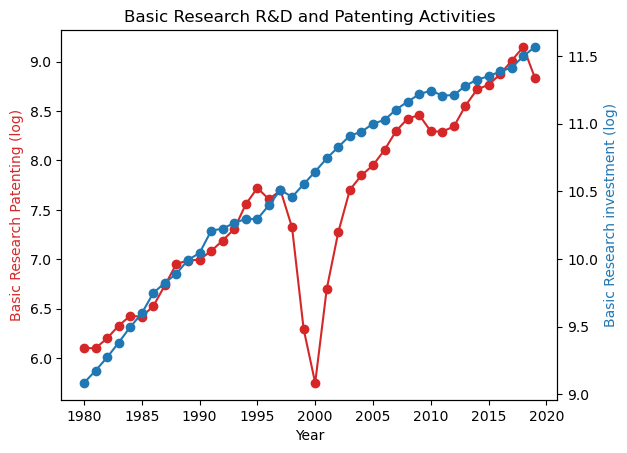

In [90]:
fig, ax1 = plt.subplots()

# Plot Temperature on the primary y-axis
ax1.plot(data['year'], data['patent_blevel'], color='tab:red', marker='o')
ax1.set_xlabel('Year')
ax1.set_ylabel('Basic Research Patenting (log)', color='tab:red')

# Create a twin of the x-axis
ax2 = ax1.twinx()

# Plot Rainfall on the secondary y-axis
ax2.plot(data['year'], data['RD_blevel'], color='tab:blue', marker='o')
ax2.set_ylabel('Basic Research investment (log)', color='tab:blue')

plt.title('Basic Research R&D and Patenting Activities')
plt.show()

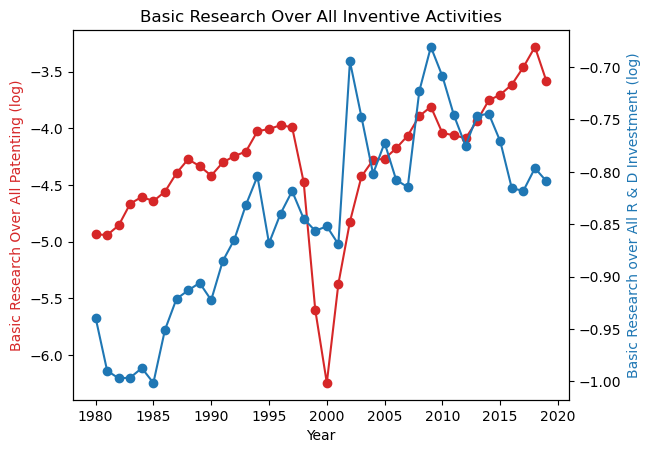

In [92]:
fig, ax1 = plt.subplots()

# Plot Temperature on the primary y-axis
ax1.plot(data['year'], data['patent_bratio'], color='tab:red', marker='o')
ax1.set_xlabel('Year')
ax1.set_ylabel('Basic Research Over All Patenting (log)', color='tab:red')

# Create a twin of the x-axis
ax2 = ax1.twinx()

# Plot Rainfall on the secondary y-axis
ax2.plot(data['year'], data['RD_bratio'], color='tab:blue', marker='o')
ax2.set_ylabel('Basic Research over All R & D Investment (log)', color='tab:blue')

plt.title('Basic Research Over All Inventive Activities')
plt.show()

### VAR Analysis

In [93]:
def var_model(data, var, var2):
    model = VAR(data)
    lag_order = model.select_order()  # 2 lags is ideal
    print(lag_order.summary())  
    print(f"Optimal lag order based on AIC: {lag_order.selected_orders['aic']}") #Akaike Information Criterion (AIC) and 
    var_model = model.fit(lag_order.selected_orders['aic'])
    print(var_model.summary())
    irf = var_model.irf(10)
    irf.plot(impulse=var, orth=False)
    plt.show()

    granger_test_x_y = var_model.test_causality(var, var2, kind='f')  # Test if 'x' Granger-causes 'y'
    granger_test_y_x = var_model.test_causality(var2, var, kind='f')  # Test if 'y' Granger-causes 'x'

    print("Granger Causality Test (x -> y):")
    print(granger_test_x_y.summary())
    
    print("\nGranger Causality Test (y -> x):")
    print(granger_test_y_x.summary())


### 2.1 Two Variables Analysis (BRatio and Productivity)

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -6.648      -6.554    0.001297      -6.618
1       -8.262      -7.981   0.0002586      -8.172
2       -8.586      -8.119   0.0001878      -8.437
3      -8.812*     -8.158*  0.0001515*     -8.603*
4       -8.658      -7.818   0.0001804      -8.390
5       -8.517      -7.490   0.0002148      -8.189
6       -8.393      -7.179   0.0002560      -8.005
7       -8.268      -6.867   0.0003124      -7.820
8       -8.329      -6.741   0.0003270      -7.821
9       -8.589      -6.814   0.0002934      -8.021
10      -8.684      -6.722   0.0003305      -8.056
--------------------------------------------------
Optimal lag order based on AIC: 3
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 08, Dec, 2024
Time:                     21:30:13
--------------------------

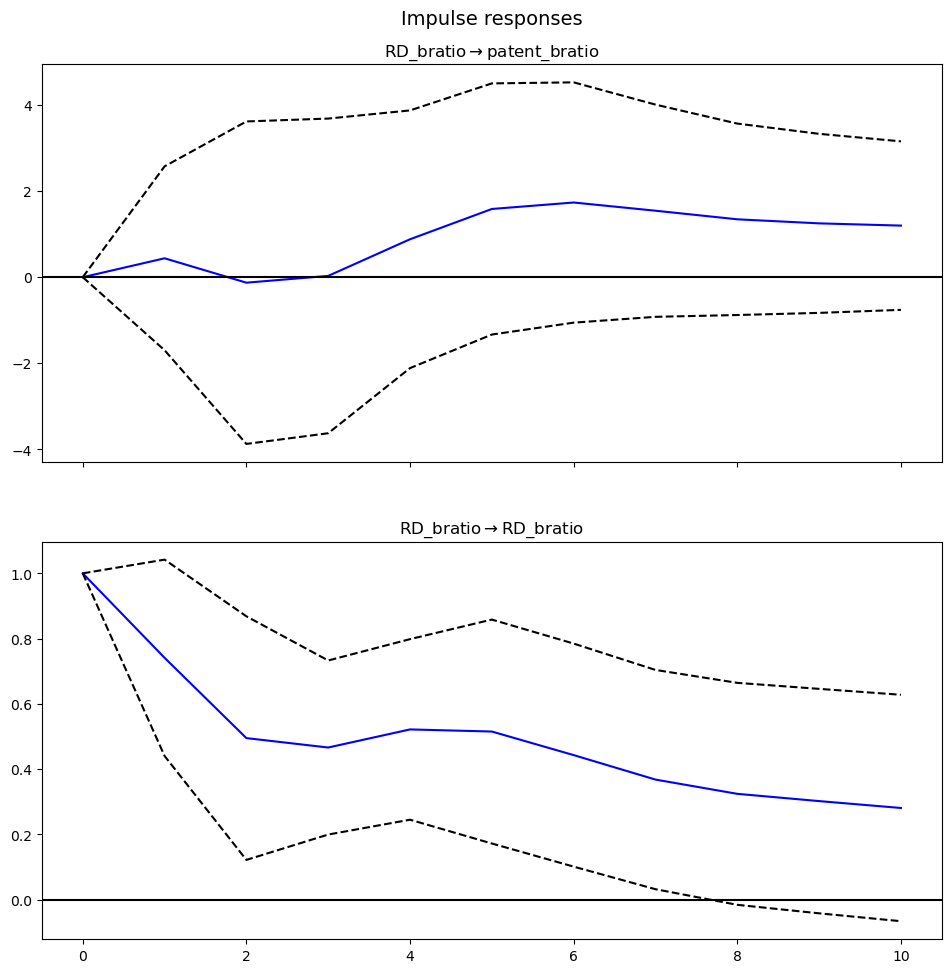

Granger Causality Test (x -> y):
Granger causality F-test. H_0: patent_bratio does not Granger-cause RD_bratio. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df  
---------------------------------------------
         5.110          2.758   0.003 (3, 60)
---------------------------------------------

Granger Causality Test (y -> x):
Granger causality F-test. H_0: RD_bratio does not Granger-cause patent_bratio. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value    df  
---------------------------------------------
        0.7829          2.758   0.508 (3, 60)
---------------------------------------------


In [97]:
var_model(smdata[['patent_bratio', 'RD_bratio']], 'RD_bratio', 'patent_bratio')

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -2.854      -2.761     0.05759      -2.825
1       -8.326     -8.046*   0.0002424      -8.236
2      -8.493*      -8.026  0.0002062*     -8.344*
3       -8.342      -7.688   0.0002424      -8.133
4       -8.356      -7.515   0.0002441      -8.087
5       -8.439      -7.412   0.0002322      -8.111
6       -8.374      -7.160   0.0002609      -7.986
7       -8.167      -6.766   0.0003458      -7.718
8       -8.321      -6.733   0.0003296      -7.813
9       -8.310      -6.535   0.0003876      -7.742
10      -8.117      -6.155   0.0005828      -7.489
--------------------------------------------------
Optimal lag order based on AIC: 2
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 08, Dec, 2024
Time:                     21:30:14
--------------------------

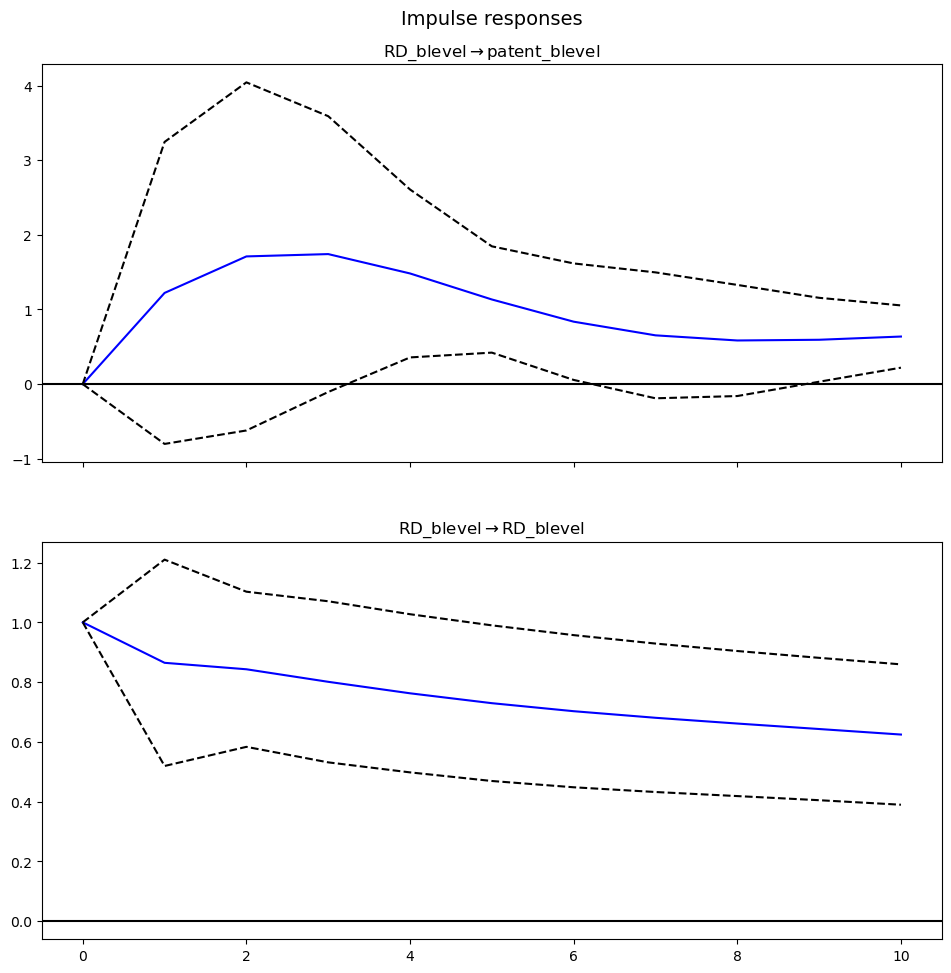

Granger Causality Test (x -> y):
Granger causality F-test. H_0: patent_blevel does not Granger-cause RD_blevel. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value    df  
---------------------------------------------
        0.7345          3.136   0.484 (2, 66)
---------------------------------------------

Granger Causality Test (y -> x):
Granger causality F-test. H_0: RD_blevel does not Granger-cause patent_blevel. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df  
---------------------------------------------
         5.079          3.136   0.009 (2, 66)
---------------------------------------------


In [98]:
var_model(smdata[['patent_blevel', 'RD_blevel']], 'RD_blevel', 'patent_blevel')

# 2. Stationarity Test

In [12]:
def stationarity_test(data, col):
    adf_result = adfuller(data[col])
    
    print("ADF Statistic:", adf_result[0])
    print("p-value:", adf_result[1])
    print("Critical Values:", adf_result[4])
    
    # Decision based on p-value
    alpha = 0.05  # significance level
    if adf_result[1] < alpha:
        print("Reject the null hypothesis (H0): The series is stationary.")
    else:
        print("Fail to reject the null hypothesis (H0): The series has a unit root and is non-stationary.")

In [13]:
for col in ['RD_blevel', 'patent_blevel', 'RD_bratio', 'patent_bratio', 'tfp', 'gdp', 'investment', 'hours']:
    print(col)
    stationarity_test(data, col)  #CONFIRMING NON-STATIONARITY

RD_blevel
ADF Statistic: -3.3865146938115056
p-value: 0.011427265533535366
Critical Values: {'1%': -3.610399601308181, '5%': -2.939108945868946, '10%': -2.6080629651545038}
Reject the null hypothesis (H0): The series is stationary.
patent_blevel
ADF Statistic: -1.1849694126081567
p-value: 0.6800278418135964
Critical Values: {'1%': -3.6209175221605827, '5%': -2.9435394610388332, '10%': -2.6104002410518627}
Fail to reject the null hypothesis (H0): The series has a unit root and is non-stationary.
RD_bratio
ADF Statistic: -1.7321976825997236
p-value: 0.4146042414173428
Critical Values: {'1%': -3.610399601308181, '5%': -2.939108945868946, '10%': -2.6080629651545038}
Fail to reject the null hypothesis (H0): The series has a unit root and is non-stationary.
patent_bratio
ADF Statistic: -1.9584208620269887
p-value: 0.3050962293245456
Critical Values: {'1%': -3.6209175221605827, '5%': -2.9435394610388332, '10%': -2.6104002410518627}
Fail to reject the null hypothesis (H0): The series has a uni

# 3. VECM Model

## 3.1 Two-variables (with TFP)

10
Cointegration Test Statistics:  [13.04387206  2.81193248]
Critical Values:  [[16.1619 18.3985 23.1485]
 [ 2.7055  3.8415  6.6349]]
Det. terms outside the coint. relation & lagged endog. parameters for equation patent_blevel
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
L1.patent_blevel     0.4992      0.175      2.853      0.004       0.156       0.842
L1.tfp               0.7176      6.648      0.108      0.914     -12.312      13.747
L2.patent_blevel    -0.5127      0.197     -2.608      0.009      -0.898      -0.127
L2.tfp               2.3289      6.025      0.387      0.699      -9.480      14.137
L3.patent_blevel     0.0112      0.215      0.052      0.958      -0.411       0.433
L3.tfp               9.7903      5.807      1.686      0.092      -1.591      21.171
L4.patent_blevel    -0.0564      0.200     -0.282      0.778      -0.448       0.335
L4.tfp  

<Figure size 1200x600 with 0 Axes>

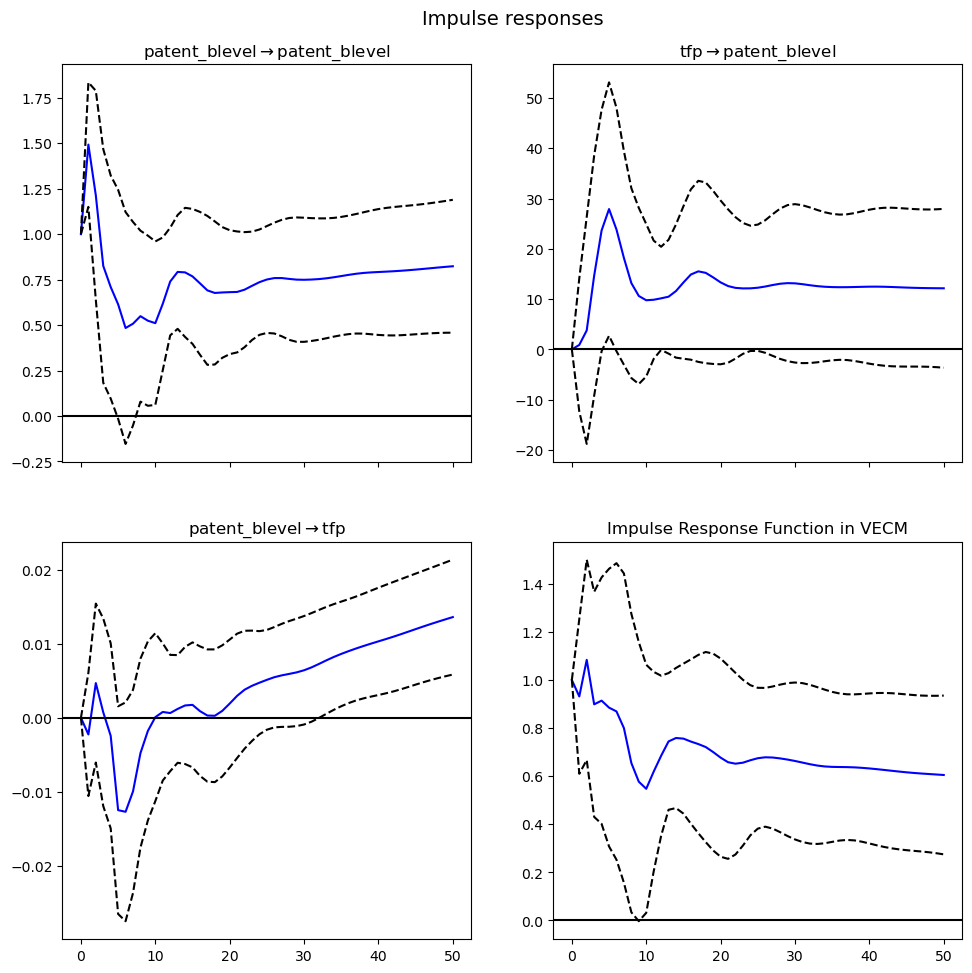

In [143]:
# Johansen Cointegration Test
df = smdata[['patent_blevel','tfp']]

model = VAR(df)
lag_order = model.select_order()  
lag = lag_order.selected_orders['aic']
print(lag)
lag=5

coint_test = statsmodels.tsa.vector_ar.vecm.coint_johansen(df, det_order=1, k_ar_diff=lag)
coint_rank = coint_test.lr1  # Test statistic for the rank of cointegration space
print("Cointegration Test Statistics: ", coint_rank)
print("Critical Values: ", coint_test.cvt)

# Fit VECM based on the cointegration rank
vecm_model = sm.tsa.VECM(df, coint_rank=1, k_ar_diff=lag)  # Adjust coint_rank as necessary
vecm_result = vecm_model.fit()

# Summary of VECM results
print(vecm_result.summary())

# Impulse Response Functions
irf = vecm_result.irf(50)  # 10 periods ahead
plt.figure(figsize=(12, 6))
irf.plot()
plt.title('Impulse Response Function in VECM')
plt.show()

2
Cointegration Test Statistics:  [12.11817266  2.77161568]
Trace Statistic:  [12.11817266  2.77161568]
Critical Values:  [[16.1619 18.3985 23.1485]
 [ 2.7055  3.8415  6.6349]]
Det. terms outside the coint. relation & lagged endog. parameters for equation patent_bratio
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
L1.patent_bratio     0.5732      0.188      3.042      0.002       0.204       0.942
L1.tfp               1.4262      7.523      0.190      0.850     -13.320      16.172
L2.patent_bratio    -0.5434      0.216     -2.516      0.012      -0.967      -0.120
L2.tfp               2.6983      6.815      0.396      0.692     -10.659      16.055
L3.patent_bratio     0.0341      0.236      0.145      0.885      -0.428       0.496
L3.tfp               6.6506      6.431      1.034      0.301      -5.955      19.256
L4.patent_bratio    -0.1155      0.214     -0.539 

<Figure size 1200x600 with 0 Axes>

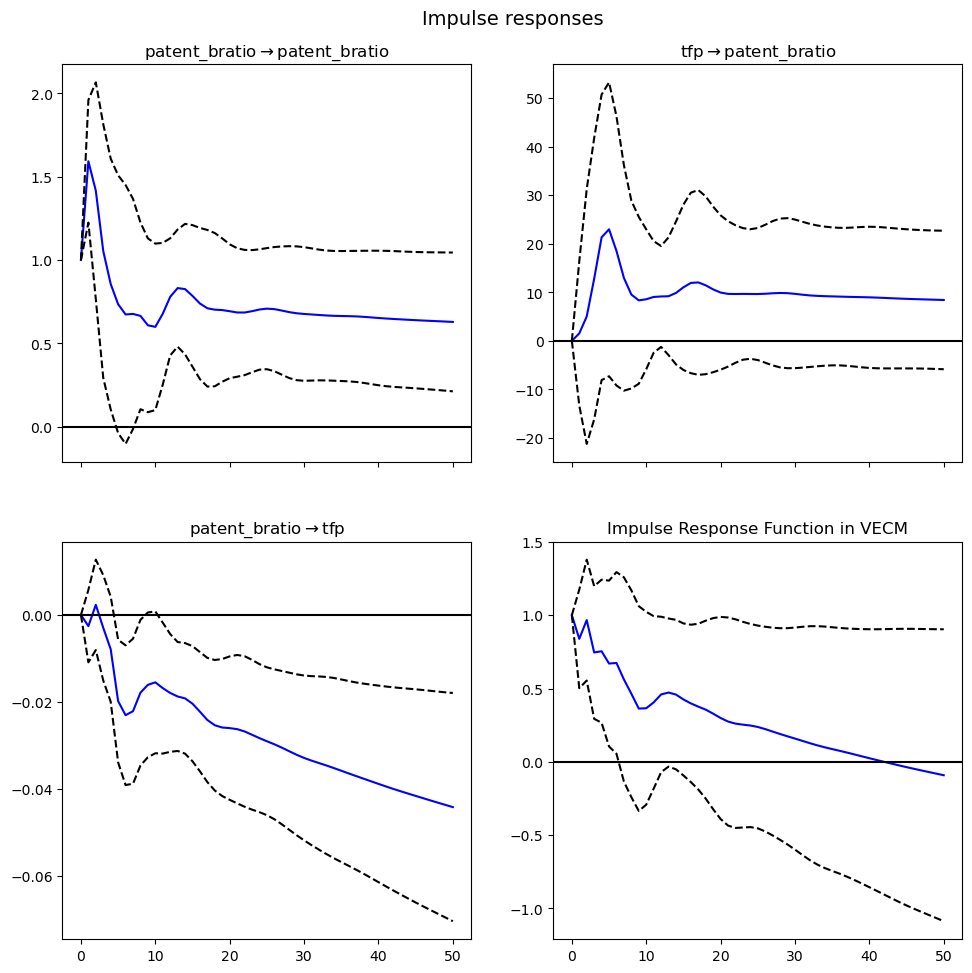

In [145]:
# Johansen Cointegration Test
df = smdata[['patent_bratio','tfp']]

model = VAR(df)
lag_order = model.select_order()  
lag = lag_order.selected_orders['aic']
print(lag)
lag=5

coint_test = statsmodels.tsa.vector_ar.vecm.coint_johansen(df, det_order=1, k_ar_diff=lag)
coint_rank = coint_test.lr1  # Test statistic for the rank of cointegration space
print("Cointegration Test Statistics: ", coint_rank)
print("Trace Statistic: ", coint_test.lr1)
print("Critical Values: ", coint_test.cvt)

# Fit VECM based on the cointegration rank
vecm_model = sm.tsa.VECM(df, coint_rank=1, k_ar_diff=lag)  # Adjust coint_rank as necessary
vecm_result = vecm_model.fit()

# Summary of VECM results
print(vecm_result.summary())

# Impulse Response Functions
irf = vecm_result.irf(50)  # 10 periods ahead
plt.figure(figsize=(12, 6))
irf.plot()
plt.title('Impulse Response Function in VECM')
plt.show()

10
Cointegration Test Statistics:  [19.75208066  2.82106425]
Trace Statistic:  [19.75208066  2.82106425]
Critical Values:  [[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
Det. terms outside the coint. relation & lagged endog. parameters for equation RD_blevel
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
L1.RD_blevel    -0.0732      0.157     -0.467      0.640      -0.380       0.234
L1.tfp           0.4868      1.023      0.476      0.634      -1.519       2.492
L2.RD_blevel    -0.1678      0.161     -1.044      0.297      -0.483       0.147
L2.tfp          -0.0582      0.973     -0.060      0.952      -1.965       1.849
L3.RD_blevel     0.0156      0.154      0.101      0.919      -0.287       0.318
L3.tfp           2.6104      0.878      2.974      0.003       0.890       4.330
L4.RD_blevel    -0.2544      0.158     -1.606      0.108      -0.565       0.056
L4.t

<Figure size 1200x600 with 0 Axes>

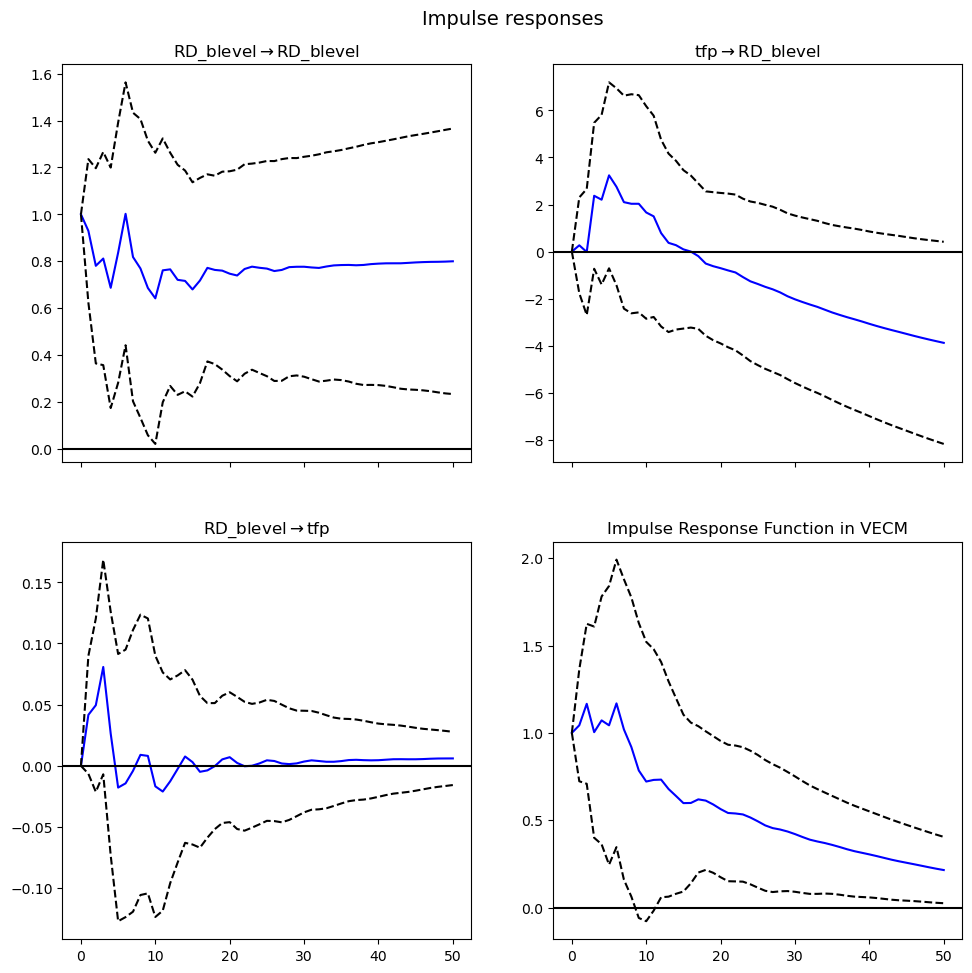

In [148]:
# Johansen Cointegration Test
df = smdata[['RD_blevel','tfp']]

model = VAR(df)
lag_order = model.select_order()  
lag = lag_order.selected_orders['aic']
print(lag)
lag=5

coint_test = statsmodels.tsa.vector_ar.vecm.coint_johansen(df, det_order=0, k_ar_diff=lag)
coint_rank = coint_test.lr1  # Test statistic for the rank of cointegration space
print("Cointegration Test Statistics: ", coint_rank)
print("Trace Statistic: ", coint_test.lr1)
print("Critical Values: ", coint_test.cvt)

# Fit VECM based on the cointegration rank
vecm_model = sm.tsa.VECM(df, coint_rank=1, k_ar_diff=lag)  # Adjust coint_rank as necessary
vecm_result = vecm_model.fit()

# Summary of VECM results
print(vecm_result.summary())

# Impulse Response Functions
irf = vecm_result.irf(50)  # 10 periods ahead
plt.figure(figsize=(12, 6))
irf.plot()
plt.title('Impulse Response Function in VECM')
plt.show()

1
Cointegration Test Statistics:  [9.10421289 0.73114191]
Trace Statistic:  [9.10421289 0.73114191]
Critical Values:  [[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
Det. terms outside the coint. relation & lagged endog. parameters for equation RD_bratio
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
L1.RD_bratio    -0.1181      0.151     -0.780      0.436      -0.415       0.179
L1.tfp          -1.2993      0.781     -1.664      0.096      -2.830       0.231
Det. terms outside the coint. relation & lagged endog. parameters for equation tfp
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
L1.RD_bratio     0.0454      0.030      1.498      0.134      -0.014       0.105
L1.tfp           0.0026      0.156      0.017      0.987      -0.304       0.309
       

<Figure size 1200x600 with 0 Axes>

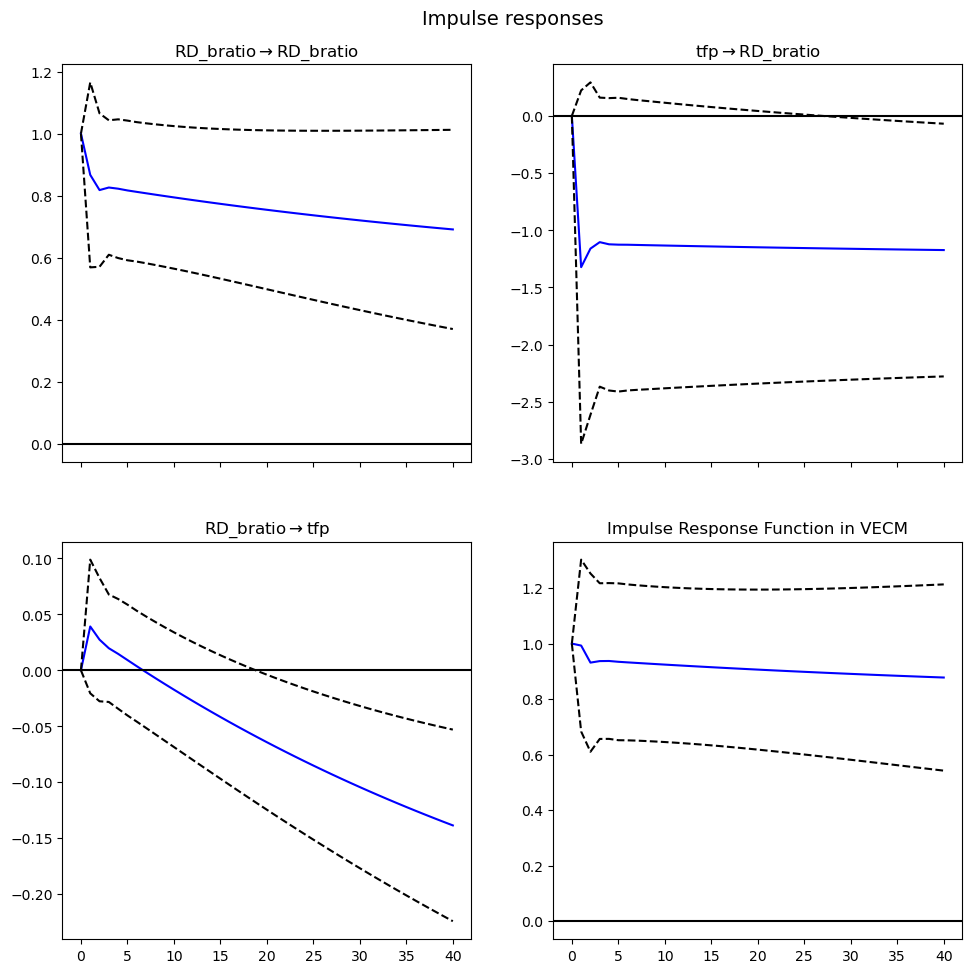

In [147]:
# Johansen Cointegration Test
df = smdata[['RD_bratio','tfp']]

model = VAR(df)
lag_order = model.select_order()  
lag = lag_order.selected_orders['aic']
print(lag)

coint_test = statsmodels.tsa.vector_ar.vecm.coint_johansen(df, det_order=0, k_ar_diff=lag)
coint_rank = coint_test.lr1  # Test statistic for the rank of cointegration space
print("Cointegration Test Statistics: ", coint_rank)
print("Trace Statistic: ", coint_test.lr1)
print("Critical Values: ", coint_test.cvt)

# Fit VECM based on the cointegration rank
vecm_model = sm.tsa.VECM(df, coint_rank=1, k_ar_diff=lag)  # Adjust coint_rank as necessary
vecm_result = vecm_model.fit()

# Summary of VECM results
print(vecm_result.summary())

# Impulse Response Functions
irf = vecm_result.irf(40)  # 10 periods ahead
plt.figure(figsize=(12, 6))
irf.plot()
plt.title('Impulse Response Function in VECM')
plt.show()

## 3.2 Three variates Model (with TFP and GDP)

9
Cointegration Test Statistics:  [28.25390915 12.60374593  0.73727568]
Critical Values:  [[27.0669 29.7961 35.4628]
 [13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
Det. terms outside the coint. relation & lagged endog. parameters for equation patent_blevel
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
L1.patent_blevel     0.2215      0.237      0.934      0.350      -0.243       0.686
L1.tfp               6.3466     12.040      0.527      0.598     -17.251      29.945
L1.gdp              -4.2493      5.562     -0.764      0.445     -15.151       6.653
L2.patent_blevel    -0.7981      0.219     -3.652      0.000      -1.226      -0.370
L2.tfp              31.3957     10.977      2.860      0.004       9.882      52.910
L2.gdp             -13.5221      5.688     -2.377      0.017     -24.671      -2.373
L3.patent_blevel    -0.0916      0.237     -0.387      

<Figure size 1200x600 with 0 Axes>

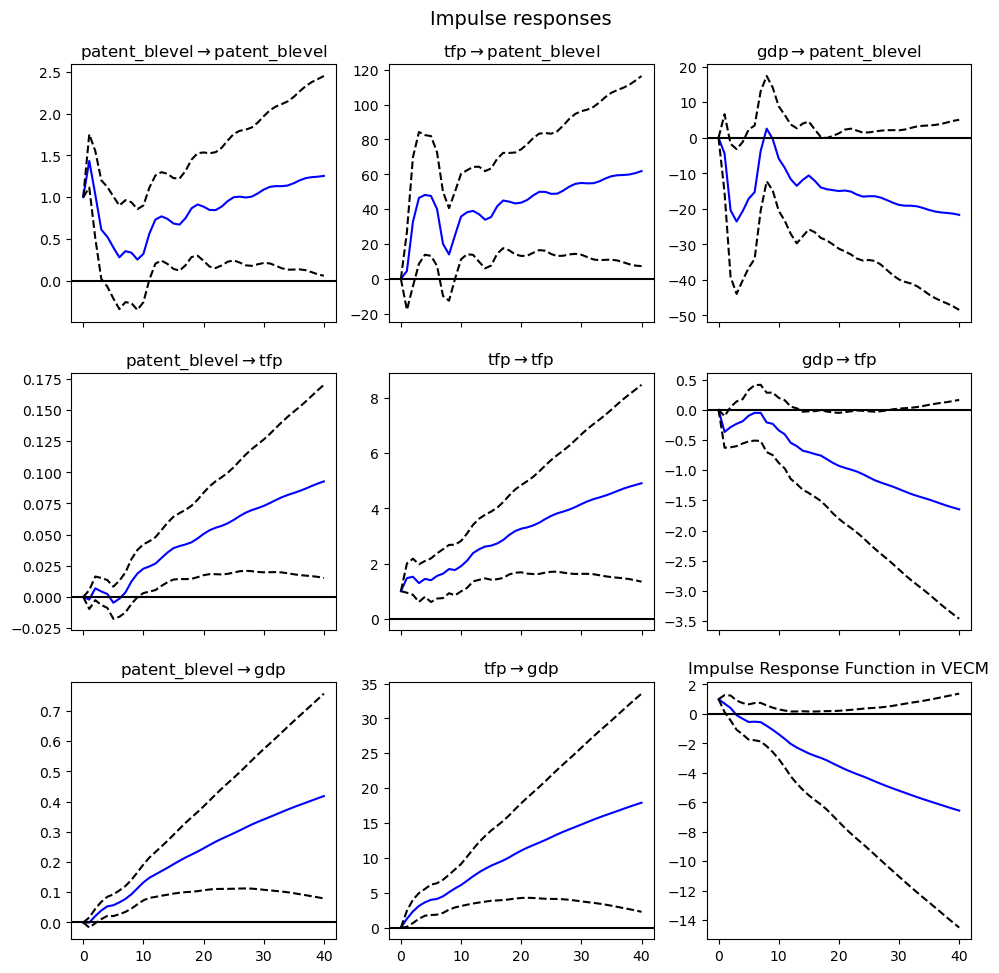

In [153]:
# Johansen Cointegration Test
df = smdata[['patent_blevel','tfp', 'gdp']]

model = VAR(df)
lag_order = model.select_order()  
lag = lag_order.selected_orders['aic']
print(lag)
lag=5

coint_test = statsmodels.tsa.vector_ar.vecm.coint_johansen(df, det_order=0, k_ar_diff=lag)
coint_rank = coint_test.lr1  # Test statistic for the rank of cointegration space
print("Cointegration Test Statistics: ", coint_rank)
print("Critical Values: ", coint_test.cvt)

# Fit VECM based on the cointegration rank
vecm_model = sm.tsa.VECM(df, coint_rank=1, k_ar_diff=lag)  # Adjust coint_rank as necessary
vecm_result = vecm_model.fit()

# Summary of VECM results
print(vecm_result.summary())

# Impulse Response Functions
irf = vecm_result.irf(40)  # 10 periods ahead
plt.figure(figsize=(12, 6))
irf.plot()
plt.title('Impulse Response Function in VECM')
plt.show()

9
Cointegration Test Statistics:  [27.37832881 12.19757681  0.32052706]
Trace Statistic:  [27.37832881 12.19757681  0.32052706]
Critical Values:  [[27.0669 29.7961 35.4628]
 [13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
Det. terms outside the coint. relation & lagged endog. parameters for equation patent_bratio
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
L1.patent_bratio     0.3930      0.263      1.497      0.134      -0.122       0.908
L1.tfp               5.7790     12.481      0.463      0.643     -18.683      30.241
L1.gdp              -3.0841      6.040     -0.511      0.610     -14.923       8.754
L2.patent_bratio    -0.7018      0.234     -2.996      0.003      -1.161      -0.243
L2.tfp              26.2536     11.723      2.239      0.025       3.277      49.230
L2.gdp             -11.4559      6.017     -1.904      0.057     -23.249       0.337

<Figure size 1200x600 with 0 Axes>

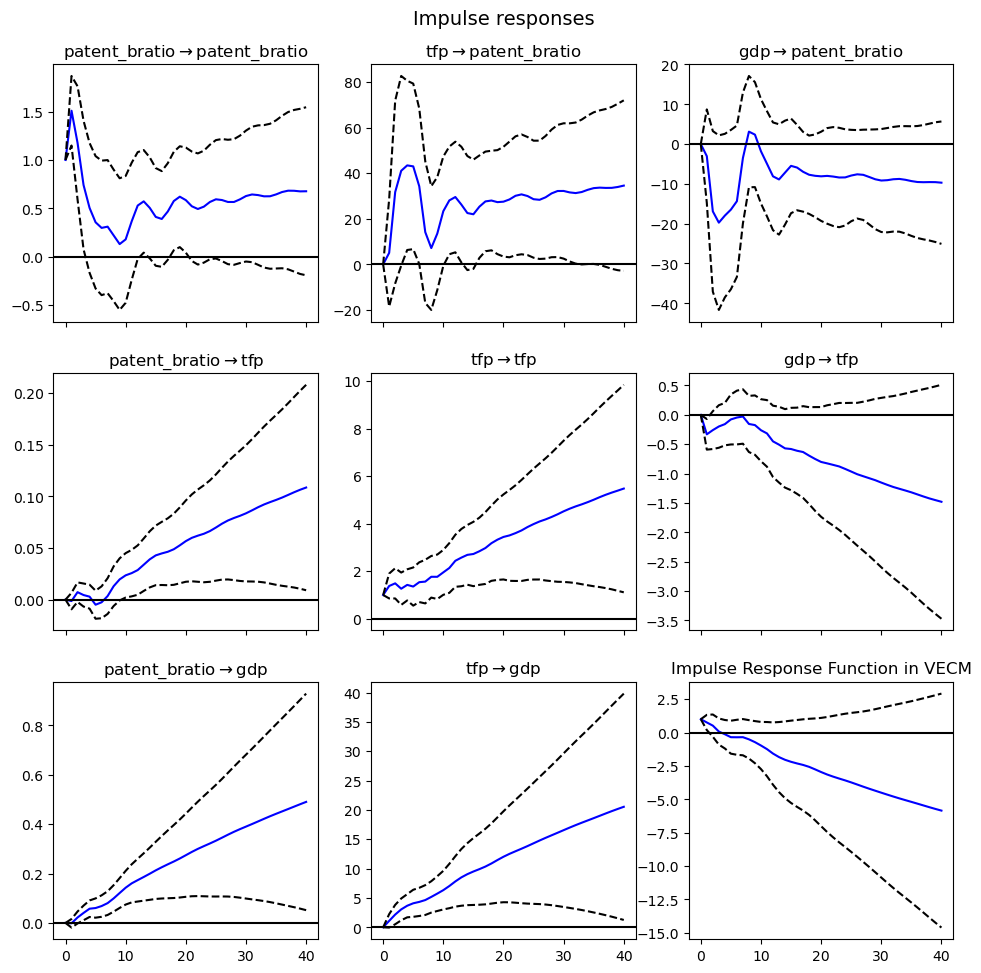

In [154]:
# Johansen Cointegration Test
df = smdata[['patent_bratio','tfp', 'gdp']]

model = VAR(df)
lag_order = model.select_order()  
lag = lag_order.selected_orders['aic']
print(lag)
lag=5

coint_test = statsmodels.tsa.vector_ar.vecm.coint_johansen(df, det_order=0, k_ar_diff=lag)
coint_rank = coint_test.lr1  # Test statistic for the rank of cointegration space
print("Cointegration Test Statistics: ", coint_rank)
print("Trace Statistic: ", coint_test.lr1)
print("Critical Values: ", coint_test.cvt)

# Fit VECM based on the cointegration rank
vecm_model = sm.tsa.VECM(df, coint_rank=1, k_ar_diff=lag)  # Adjust coint_rank as necessary
vecm_result = vecm_model.fit()

# Summary of VECM results
print(vecm_result.summary())

# Impulse Response Functions
irf = vecm_result.irf(40)  # 10 periods ahead
plt.figure(figsize=(12, 6))
irf.plot()
plt.title('Impulse Response Function in VECM')
plt.show()

9
Cointegration Test Statistics:  [44.94613286 16.66895055  5.16593309]
Trace Statistic:  [44.94613286 16.66895055  5.16593309]
Critical Values:  [[27.0669 29.7961 35.4628]
 [13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
Det. terms outside the coint. relation & lagged endog. parameters for equation RD_blevel
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
L1.RD_blevel    -0.2680      0.147     -1.821      0.069      -0.556       0.020
L1.tfp           2.6346      1.068      2.466      0.014       0.541       4.728
L1.gdp          -2.2129      0.543     -4.079      0.000      -3.276      -1.149
L2.RD_blevel    -0.3899      0.128     -3.057      0.002      -0.640      -0.140
L2.tfp          -0.4234      1.119     -0.378      0.705      -2.617       1.770
L2.gdp           0.4606      0.726      0.634      0.526      -0.963       1.885
L3.RD_blevel    -0.1145      0.134 

<Figure size 1200x600 with 0 Axes>

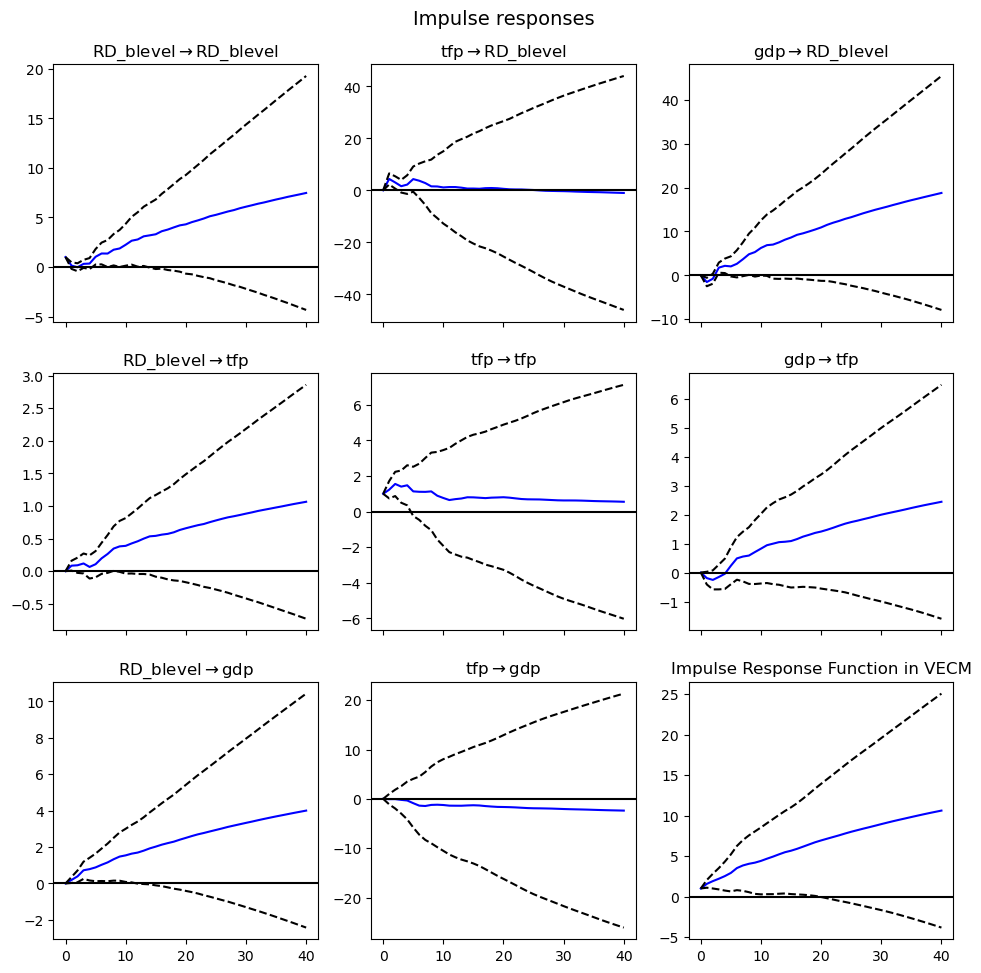

In [126]:
# Johansen Cointegration Test
df = smdata[['RD_blevel','tfp', 'gdp']]

model = VAR(df)
lag_order = model.select_order()  
lag = lag_order.selected_orders['aic']
print(lag)
lag=5

coint_test = statsmodels.tsa.vector_ar.vecm.coint_johansen(df, det_order=0, k_ar_diff=lag)
coint_rank = coint_test.lr1  # Test statistic for the rank of cointegration space
print("Cointegration Test Statistics: ", coint_rank)
print("Trace Statistic: ", coint_test.lr1)
print("Critical Values: ", coint_test.cvt)

# Fit VECM based on the cointegration rank
vecm_model = sm.tsa.VECM(df, coint_rank=1, k_ar_diff=lag)  # Adjust coint_rank as necessary
vecm_result = vecm_model.fit()

# Summary of VECM results
print(vecm_result.summary())

# Impulse Response Functions
irf = vecm_result.irf(40)  # 10 periods ahead
plt.figure(figsize=(12, 6))
irf.plot()
plt.title('Impulse Response Function in VECM')
plt.show()

9
Cointegration Test Statistics:  [41.48129082 14.10964066  0.323183  ]
Trace Statistic:  [41.48129082 14.10964066  0.323183  ]
Critical Values:  [[27.0669 29.7961 35.4628]
 [13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
Det. terms outside the coint. relation & lagged endog. parameters for equation RD_bratio
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
L1.RD_bratio    -1.0387      0.170     -6.125      0.000      -1.371      -0.706
L1.tfp           2.1040      1.178      1.787      0.074      -0.204       4.412
L1.gdp          -2.7162      0.544     -4.993      0.000      -3.782      -1.650
L2.RD_bratio    -1.1466      0.176     -6.525      0.000      -1.491      -0.802
L2.tfp           1.5676      1.128      1.389      0.165      -0.644       3.779
L2.gdp          -0.7752      0.705     -1.100      0.271      -2.156       0.606
L3.RD_bratio    -0.7972      0.184 

<Figure size 1200x600 with 0 Axes>

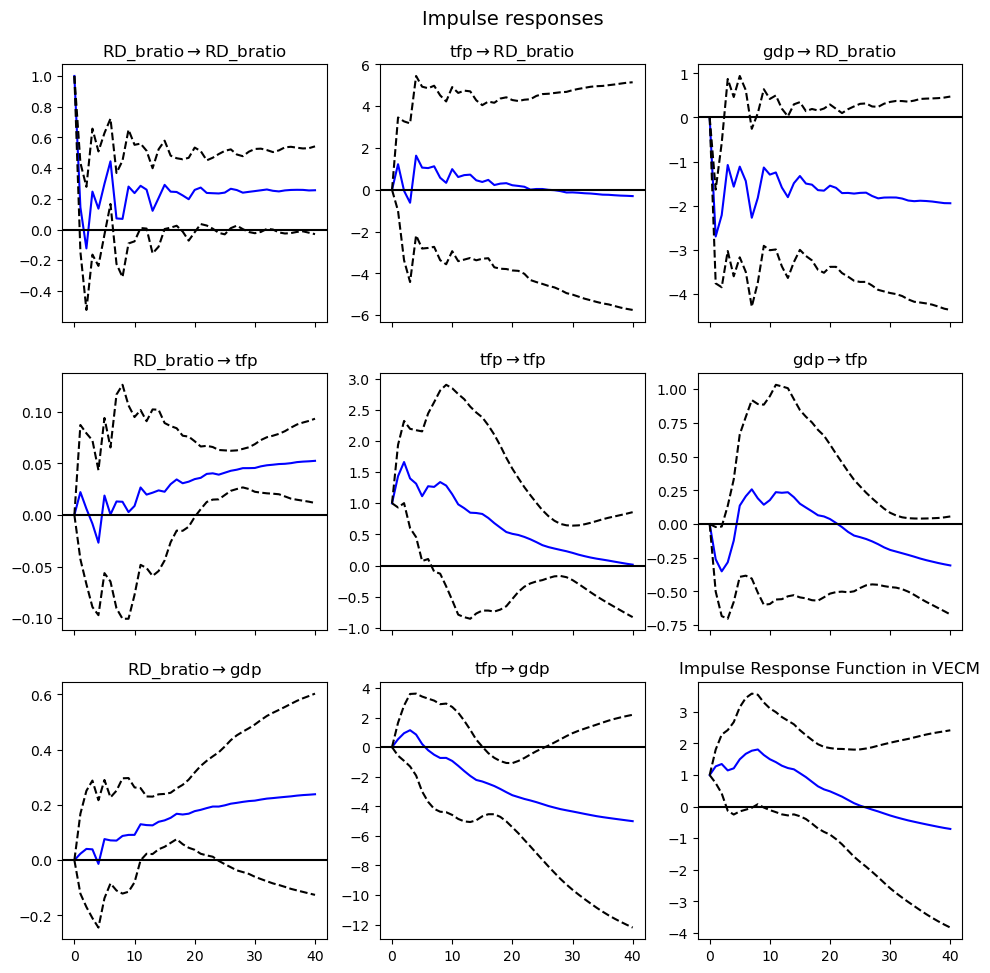

In [155]:
# Johansen Cointegration Test
df = smdata[['RD_bratio','tfp', 'gdp']]

model = VAR(df)
lag_order = model.select_order()  
lag = lag_order.selected_orders['aic']
print(lag)
lag=5

coint_test = statsmodels.tsa.vector_ar.vecm.coint_johansen(df, det_order=0, k_ar_diff=lag)
coint_rank = coint_test.lr1  # Test statistic for the rank of cointegration space
print("Cointegration Test Statistics: ", coint_rank)
print("Trace Statistic: ", coint_test.lr1)
print("Critical Values: ", coint_test.cvt)

# Fit VECM based on the cointegration rank
vecm_model = sm.tsa.VECM(df, coint_rank=1, k_ar_diff=lag)  # Adjust coint_rank as necessary
vecm_result = vecm_model.fit()

# Summary of VECM results
print(vecm_result.summary())

# Impulse Response Functions
irf = vecm_result.irf(40)  # 10 periods ahead
plt.figure(figsize=(12, 6))
irf.plot()
plt.title('Impulse Response Function in VECM')
plt.show()

## 3.2 Five-variate VECM

5
Cointegration Test Statistics:  [          nan 1047.20753824  121.5567508    66.8043252    22.08501171]
Trace Statistic:  [          nan 1047.20753824  121.5567508    66.8043252    22.08501171]
Critical Values:  [[65.8202 69.8189 77.8202]
 [44.4929 47.8545 54.6815]
 [27.0669 29.7961 35.4628]
 [13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
Det. terms outside the coint. relation & lagged endog. parameters for equation patent_blevel
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
L1.patent_blevel    -1.8533      0.326     -5.687      0.000      -2.492      -1.215
L1.tfp              84.4739     18.698      4.518      0.000      47.827     121.121
L1.gdp            -138.5412     26.304     -5.267      0.000    -190.096     -86.986
L1.investment       13.9900      2.929      4.777      0.000       8.250      19.730
L1.hours            -6.3472      7.977     -0.7

<Figure size 1200x600 with 0 Axes>

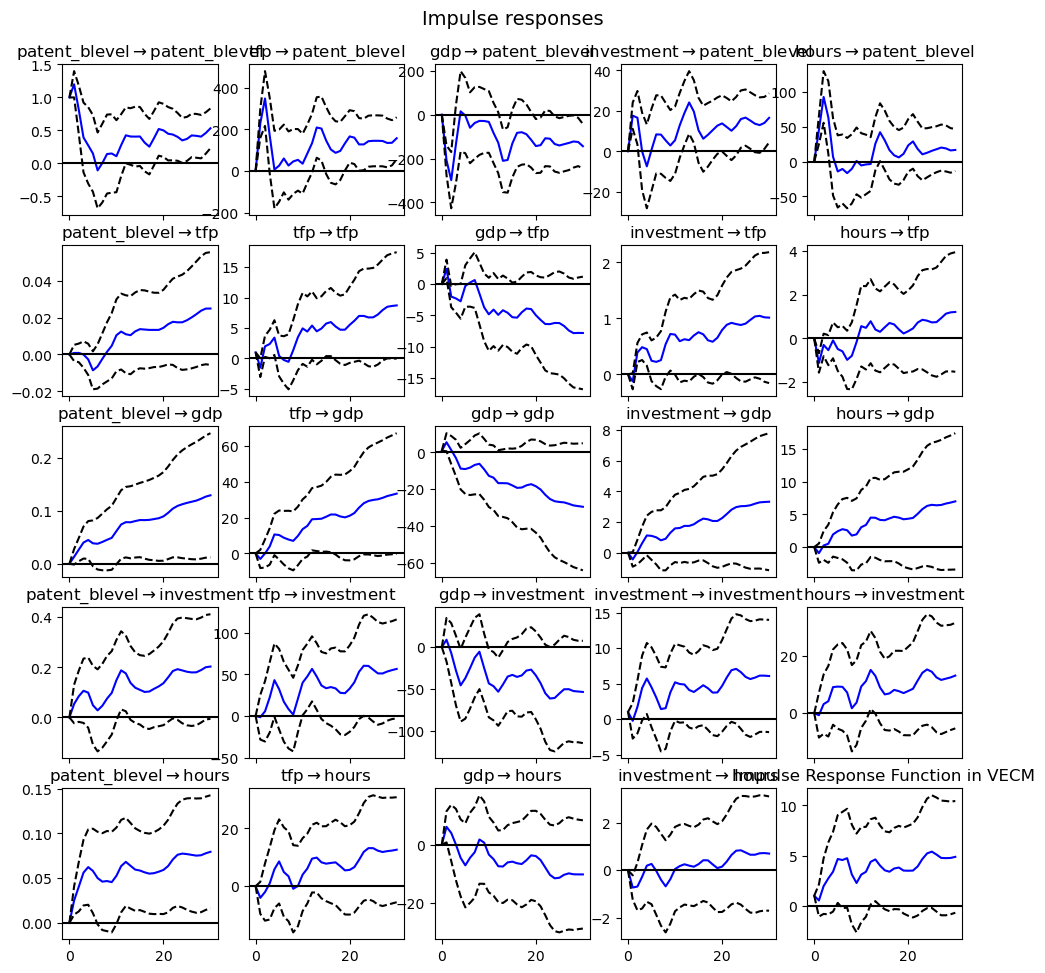

In [134]:
# Johansen Cointegration Test
df = smdata[['patent_blevel','tfp', 'gdp', 'investment', 'hours']]

model = VAR(df)
lag_order = model.select_order()  
lag = lag_order.selected_orders['aic']
print(lag)
lag=5

coint_test = statsmodels.tsa.vector_ar.vecm.coint_johansen(df, det_order=0, k_ar_diff=lag)
coint_rank = coint_test.lr1  # Test statistic for the rank of cointegration space
print("Cointegration Test Statistics: ", coint_rank)
print("Trace Statistic: ", coint_test.lr1)
print("Critical Values: ", coint_test.cvt)

# Fit VECM based on the cointegration rank
vecm_model = sm.tsa.VECM(df, coint_rank=1, k_ar_diff=lag)  # Adjust coint_rank as necessary
vecm_result = vecm_model.fit()

# Summary of VECM results
print(vecm_result.summary())

# Impulse Response Functions
irf = vecm_result.irf(30)  # 10 periods ahead
plt.figure(figsize=(12, 6))
irf.plot()
plt.title('Impulse Response Function in VECM')
plt.show()

5
Cointegration Test Statistics:  [146.50603945  89.61863246  49.37164503  26.91305919   9.80212185]
Trace Statistic:  [146.50603945  89.61863246  49.37164503  26.91305919   9.80212185]
Critical Values:  [[65.8202 69.8189 77.8202]
 [44.4929 47.8545 54.6815]
 [27.0669 29.7961 35.4628]
 [13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
Det. terms outside the coint. relation & lagged endog. parameters for equation patent_bratio
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
L1.patent_bratio     0.8812      0.211      4.168      0.000       0.467       1.296
L1.tfp              -6.6899     19.854     -0.337      0.736     -45.602      32.222
L1.gdp              21.8779     25.035      0.874      0.382     -27.190      70.946
L1.investment       -1.4665      2.190     -0.670      0.503      -5.758       2.825
L1.hours             0.0226     11.644      0.002      0.

<Figure size 1200x600 with 0 Axes>

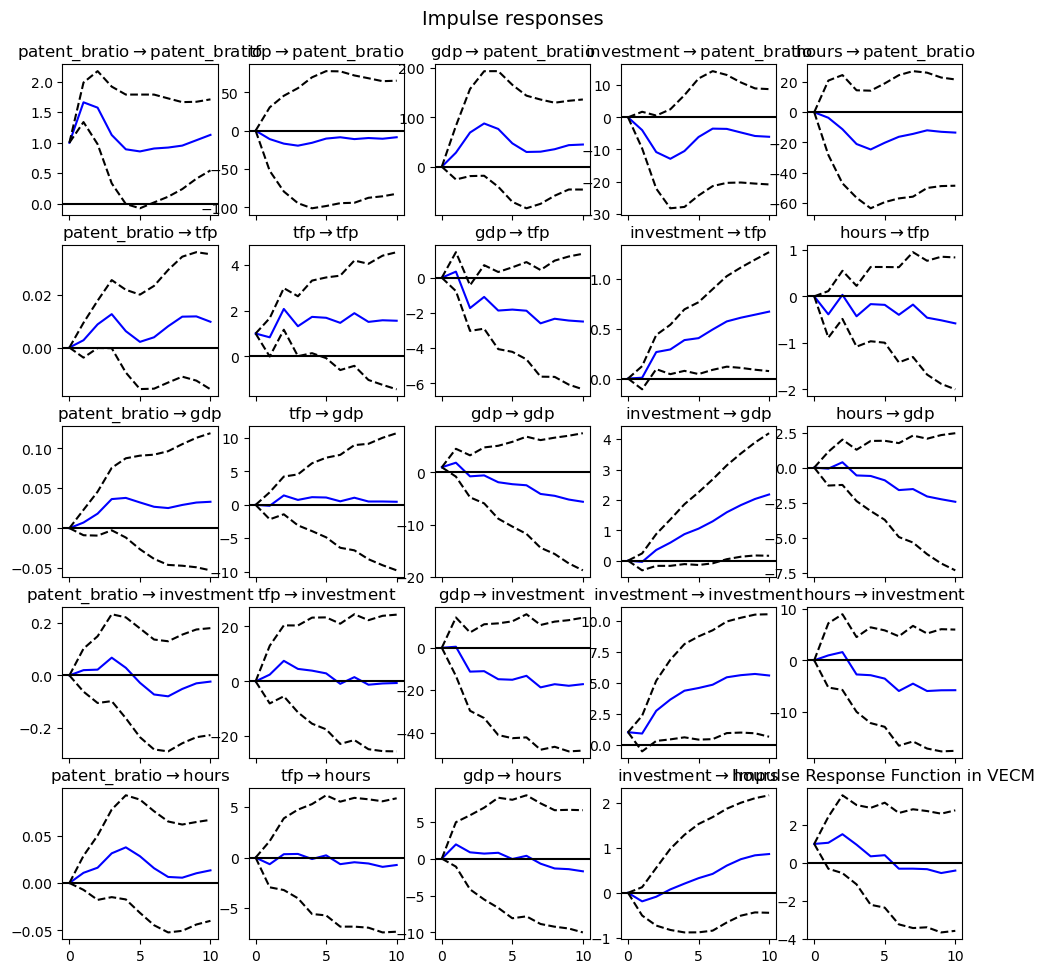

In [137]:
# Johansen Cointegration Test
df = smdata[['patent_bratio','tfp', 'gdp', 'investment', 'hours']]

model = VAR(df)
lag_order = model.select_order()  
lag = lag_order.selected_orders['aic']
print(lag)
lag=3

coint_test = statsmodels.tsa.vector_ar.vecm.coint_johansen(df, det_order=0, k_ar_diff=lag)
coint_rank = coint_test.lr1  # Test statistic for the rank of cointegration space
print("Cointegration Test Statistics: ", coint_rank)
print("Trace Statistic: ", coint_test.lr1)
print("Critical Values: ", coint_test.cvt)

# Fit VECM based on the cointegration rank
vecm_model = sm.tsa.VECM(df, coint_rank=1, k_ar_diff=lag)  # Adjust coint_rank as necessary
vecm_result = vecm_model.fit()

# Summary of VECM results
print(vecm_result.summary())

# Impulse Response Functions
irf = vecm_result.irf(10)  # 10 periods ahead
plt.figure(figsize=(12, 6))
irf.plot()
plt.title('Impulse Response Function in VECM')
plt.show()

5
Cointegration Test Statistics:  [177.61720059  98.88534789  58.81334312  34.20241515  13.10902478]
Trace Statistic:  [177.61720059  98.88534789  58.81334312  34.20241515  13.10902478]
Critical Values:  [[65.8202 69.8189 77.8202]
 [44.4929 47.8545 54.6815]
 [27.0669 29.7961 35.4628]
 [13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
Det. terms outside the coint. relation & lagged endog. parameters for equation RD_blevel
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
L1.RD_blevel     -0.3449      0.124     -2.785      0.005      -0.588      -0.102
L1.tfp            5.1283      1.669      3.072      0.002       1.856       8.400
L1.gdp           -5.1148      1.795     -2.849      0.004      -8.633      -1.596
L1.investment    -0.1042      0.210     -0.495      0.620      -0.517       0.308
L1.hours          1.0198      1.118      0.913      0.361      -1.171       3.2

<Figure size 1200x600 with 0 Axes>

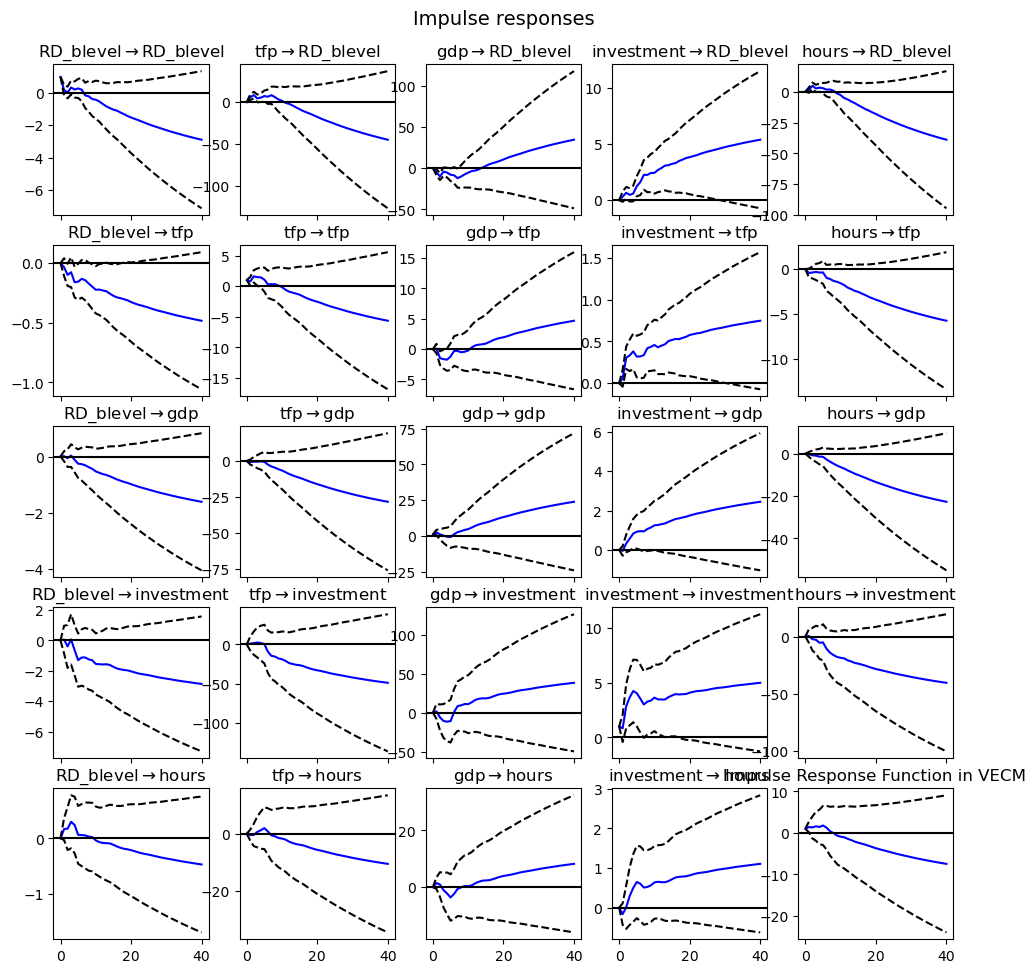

In [139]:
# Johansen Cointegration Test
df = smdata[['RD_blevel','tfp', 'gdp', 'investment', 'hours']]

model = VAR(df)
lag_order = model.select_order()  
lag = lag_order.selected_orders['aic']
print(lag)
lag=3

coint_test = statsmodels.tsa.vector_ar.vecm.coint_johansen(df, det_order=0, k_ar_diff=lag)
coint_rank = coint_test.lr1  # Test statistic for the rank of cointegration space
print("Cointegration Test Statistics: ", coint_rank)
print("Trace Statistic: ", coint_test.lr1)
print("Critical Values: ", coint_test.cvt)

# Fit VECM based on the cointegration rank
vecm_model = sm.tsa.VECM(df, coint_rank=1, k_ar_diff=lag)  # Adjust coint_rank as necessary
vecm_result = vecm_model.fit()

# Summary of VECM results
print(vecm_result.summary())

# Impulse Response Functions
irf = vecm_result.irf(40)  # 10 periods ahead
plt.figure(figsize=(12, 6))
irf.plot()
plt.title('Impulse Response Function in VECM')
plt.show()

5
Cointegration Test Statistics:  [          nan 1099.26454855   99.93377702   45.18643159    8.76204968]
Trace Statistic:  [          nan 1099.26454855   99.93377702   45.18643159    8.76204968]
Critical Values:  [[65.8202 69.8189 77.8202]
 [44.4929 47.8545 54.6815]
 [27.0669 29.7961 35.4628]
 [13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
Det. terms outside the coint. relation & lagged endog. parameters for equation RD_bratio
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
L1.RD_bratio     -1.7687      0.298     -5.929      0.000      -2.353      -1.184
L1.tfp           12.3329      2.833      4.353      0.000       6.780      17.886
L1.gdp           -7.7365      2.626     -2.946      0.003     -12.883      -2.590
L1.investment    -0.1244      0.443     -0.281      0.779      -0.993       0.745
L1.hours          3.4823      1.240      2.808      0.005       1.051

<Figure size 1200x600 with 0 Axes>

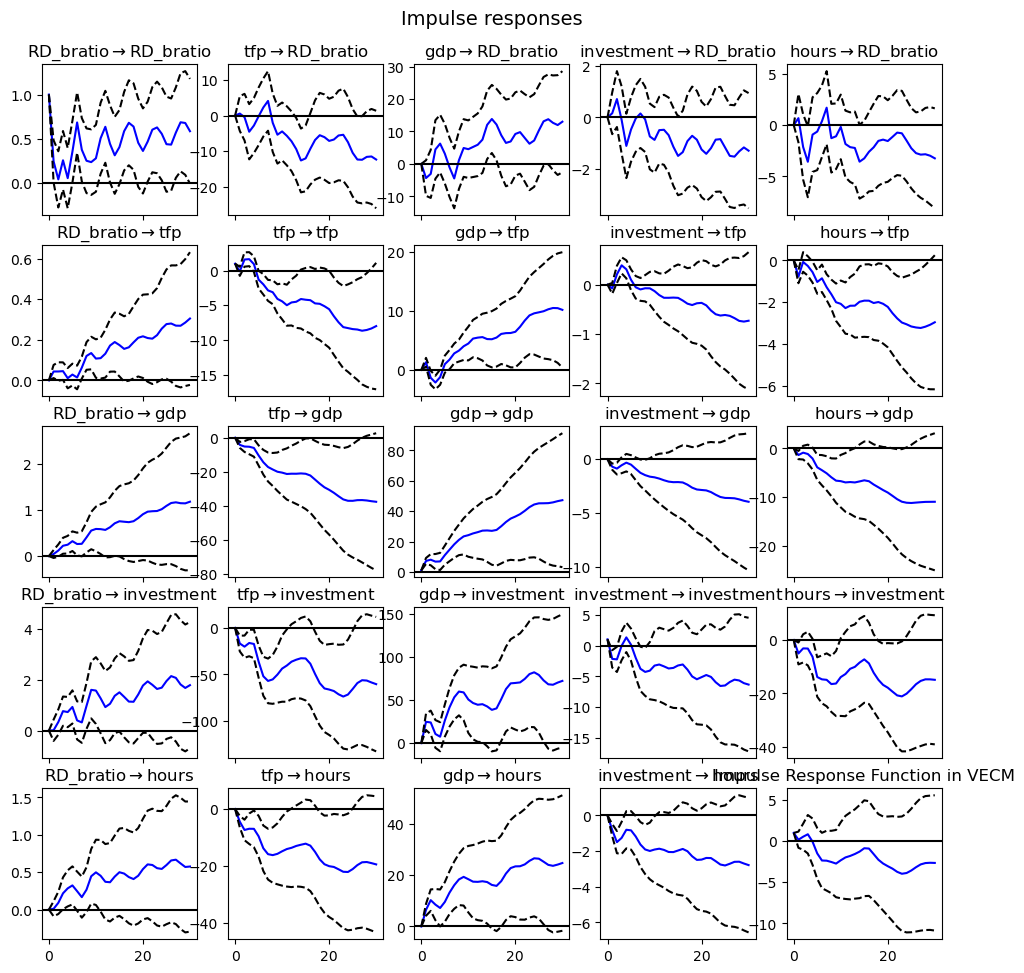

In [140]:
# Johansen Cointegration Test
df = smdata[['RD_bratio','tfp', 'gdp', 'investment', 'hours']]

model = VAR(df)
lag_order = model.select_order()  
lag = lag_order.selected_orders['aic']
print(lag)
lag=5

coint_test = statsmodels.tsa.vector_ar.vecm.coint_johansen(df, det_order=0, k_ar_diff=lag)
coint_rank = coint_test.lr1  # Test statistic for the rank of cointegration space
print("Cointegration Test Statistics: ", coint_rank)
print("Trace Statistic: ", coint_test.lr1)
print("Critical Values: ", coint_test.cvt)

# Fit VECM based on the cointegration rank
vecm_model = sm.tsa.VECM(df, coint_rank=1, k_ar_diff=lag)  # Adjust coint_rank as necessary
vecm_result = vecm_model.fit()

# Summary of VECM results
print(vecm_result.summary())

# Impulse Response Functions
irf = vecm_result.irf(30)  # 10 periods ahead
plt.figure(figsize=(12, 6))
irf.plot()
plt.title('Impulse Response Function in VECM')
plt.show()